In [1]:
import os
import tifffile
import rasterio

import cv2
import numpy as np

import leafmap.leafmap as leafmap
from samgeo import SamGeo2

import geopandas as gpd
import pickle
from pyproj import Transformer

from utils.tools import get_raster_data, read_geojson, show
import matplotlib.pyplot as plt


## A. Read big tif file

In [3]:
m = leafmap.Map(center=[12.94316, 101.001263], zoom=16, height="800px")
m.add_basemap("Satellite")
m

Map(center=[12.94316, 101.001263], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [4]:
if m.user_roi is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [100.9230026816609, 13.054297390119896, 100.9261026816609, 13.052397390099848]

In [5]:
clipped_satellite_file = "clipped_satellite.tif"

leafmap.map_tiles_to_geotiff(
    output=clipped_satellite_file, bbox=bbox, zoom=18, source="Satellite", overwrite=True
)

Downloaded image 1/12
Downloaded image 2/12
Downloaded image 3/12
Downloaded image 4/12
Downloaded image 5/12
Downloaded image 6/12
Downloaded image 7/12
Downloaded image 8/12
Downloaded image 9/12
Downloaded image 10/12
Downloaded image 11/12
Downloaded image 12/12
Saving GeoTIFF. Please wait...
Image saved to clipped_satellite.tif


In [6]:
selected_coordinates = {} 
selected_coordinates["bbox"] = bbox

selected_coordinates

file_path = 'selected_coordinates.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(selected_coordinates, file)

## B. Read clipped files

In [7]:
clipped_image_file = "clipped_image.tif"
clipped_satellite_file = "clipped_satellite.tif"

clipped_image     = tifffile.imread(clipped_image_file)  
clipped_satellite = tifffile.imread(clipped_satellite_file) 

In [8]:
normalized_img = cv2.normalize(clipped_image, None, 0, 256, cv2.NORM_MINMAX)  # Normalize to 0-1 range
final_img = normalized_img.astype(np.uint8) 

#lab = cv2.cvtColor(final_img, cv2.COLOR_RGB2LAB)
#l_channel, a, b = cv2.split(lab)
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#cl = clahe.apply(l_channel)

#limg = cv2.merge((cl,a,b))
#final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

In [ ]:
tifffile.imwrite('post_processed_clipped_image.tif', final_img)

In [ ]:
# Define file paths
source_tif = 'clipped_image.tif'
destination_tif = 'post_processed_clipped_image.tif'
# Example: a numpy array of data to write to the destination file
# data_array = np.random.randint(low=10, high=20, size=(360, 720)).astype('float64')

# 1. Open the source file in read mode ('r' is default)
with rasterio.open(source_tif) as src:
    # 2. Get the metadata (including CRS, transform, dimensions, etc.)
    # and create a copy of it
    dst_kwargs = src.meta.copy()
    dst_kwargs['dtype'] = 'uint8'  # Update data type if necessary

    # If you are writing a different NumPy array (e.g., of different data type or band count),
    # you may need to update 'dtype' and 'count' in dst_kwargs
    # dst_kwargs.update({'dtype': data_array.dtype, 'count': 1})

    # 3. Open the destination file in write mode
    with rasterio.open(destination_tif, 'w', **dst_kwargs) as dst:
        # 4. Write your data to the destination file
        # This example writes the data from the source file (band 1)
        # If using a new array, it would be: dst.write(data_array, 1)
        dst.write(src.read(1), 1)

(-0.5, 577.5, 363.5, -0.5)

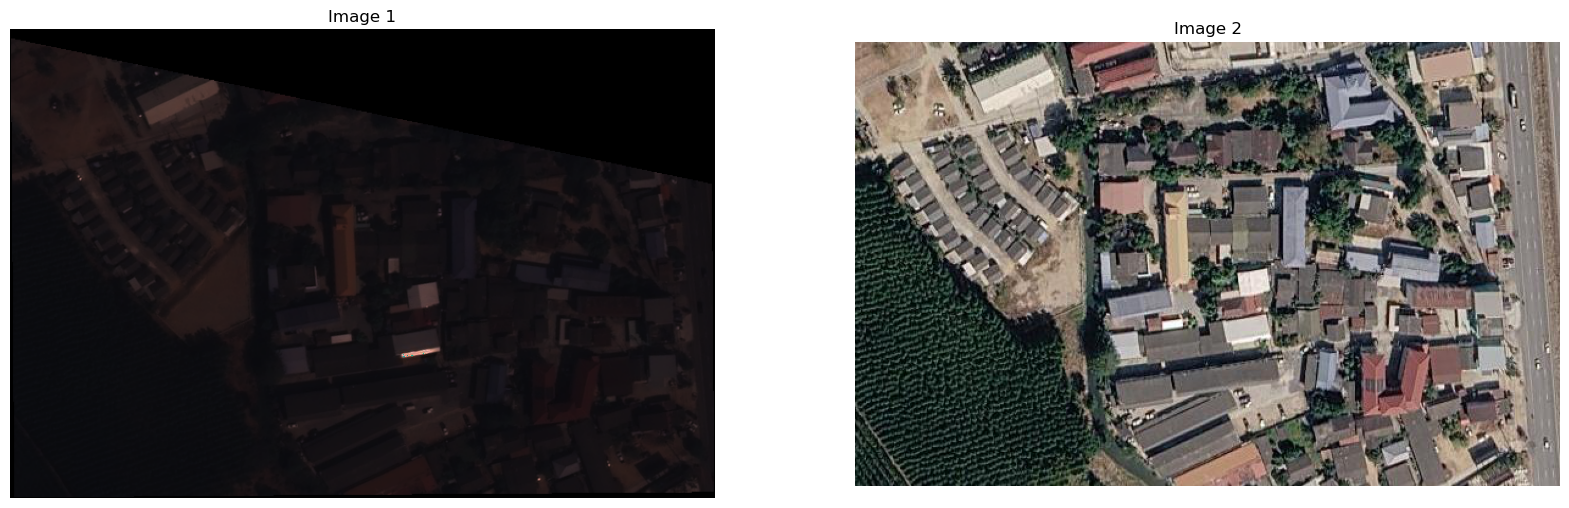

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 15))

axs[0].imshow(final_img[:,:,0:3])  # Display the first three channels (RGB) of the clipped image
axs[0].set_title('Image 1') # Set a title for the first subplot
axs[0].axis('off') # Optional: turn off axis ticks for a cleaner image display

axs[1].imshow(clipped_satellite[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[1].set_title('Image 2') # Set a title for the second subplot
axs[1].axis('off') #

In [ ]:
sam = SamGeo2(
    model_id="sam2-hiera-large",
    automatic=False
)

In [ ]:
sam.set_image(clipped_satellite_file)
sam.show_map()

## C. View masks

In [10]:
center_geojson  = "clipped_satellite_mask2_fg_markers.geojson"
clipped_image_file = "clipped_image.tif" 
clipped_satellite_file = "clipped_satellite.tif"
extracted_masks = "clipped_satellite_mask2.tif"
gpkg_path       = "clipped_satellite_mask2.gpkg"

In [11]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image")
m.add_raster(clipped_image_file, layer_name="Theos")
m.add_circle_markers_from_xy(center_geojson, radius=3, color="red", fill_color="yellow", fill_opacity=0.8
)
m.add_raster(extracted_masks, cmap="jet", nodata=0, opacity=0.7, layer_name="Building masks")
m.add_vector(gpkg_path, layer_name="Vector Data")
m

Map(center=[13.05335, 100.92455000000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

## D. Viewing and making bounding box

In [12]:
extracted_masks = "clipped_satellite_mask2.tif" 

In [13]:
mask, tif_data, [lons, lats], [rows, cols] = get_raster_data(extracted_masks)
mask_uint8 = mask.astype(np.uint8)

Dataset name: clipped_satellite_mask2.tif
File mode: r
Number of bands: 1
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (1, 364, 578)
Data type: int32


In [14]:
from pyproj import Transformer
x_str, y_str = tif_data.xy(0, 0)
transformer = Transformer.from_crs(tif_data.crs, "EPSG:4326", always_xy=True)
lon_0, lat_0 = transformer.transform(x_str, y_str)

x_end, y_end = tif_data.xy(364, 578)
transformer = Transformer.from_crs(tif_data.crs, "EPSG:4326", always_xy=True)
lon_end, lat_end = transformer.transform(x_end, y_end)

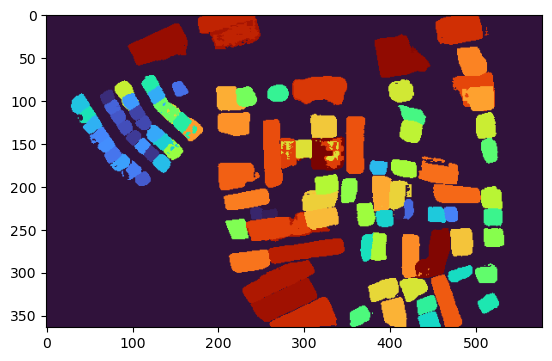

In [15]:
plt.imshow(mask_uint8[0,:,:], cmap='turbo')

In [16]:
top_left_coordinates     = [lon_0, lat_0] # long, lat 
bottom_right_coordinates = [lon_end, lat_end]  # long, lat 

image_height = mask.shape[1]
image_width = mask.shape[2]


def latlng_to_pixel(long, lat):
    lat      = lat

    min_long = min(top_left_coordinates[0], bottom_right_coordinates[0])
    max_long = max(top_left_coordinates[0], bottom_right_coordinates[0])

    min_lat  = min(top_left_coordinates[1], bottom_right_coordinates[1])
    max_lat  = max(top_left_coordinates[1], bottom_right_coordinates[1]) 

    pixel_x =  ((long - min_long) / (max_long - min_long))*image_width  
    pixel_y =  (1-(lat - min_lat) / (max_lat - min_lat))*image_height  
    pixel = [int(pixel_x), int(pixel_y)] 
    return pixel

In [17]:
center_geojson  = "clipped_satellite_mask2_fg_markers.geojson"

center = read_geojson(center_geojson)

In [18]:
center["longitude"] = center.geometry.x
center["latitude"]  = center.geometry.y

In [19]:
pixel_x = []
pixel_y = []
for long, lat in zip(center["longitude"].tolist(), center["latitude"].tolist()):
    pixel_xy = latlng_to_pixel(long, lat)
    pixel_x.append(pixel_xy[0])
    pixel_y.append(pixel_xy[1])

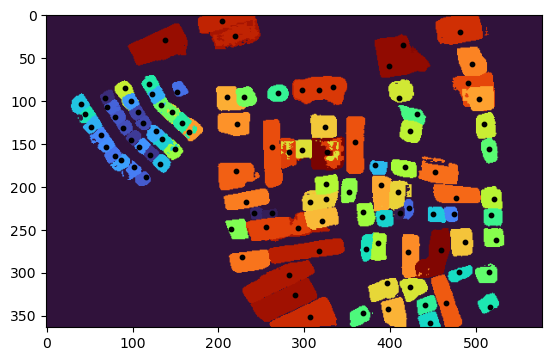

In [20]:
plt.imshow(mask_uint8[0,:,:], cmap='turbo')
plt.scatter(pixel_x, pixel_y, c='black', s=10)

In [21]:
from torchvision.ops import masks_to_boxes
import torch

tensor = torch.tensor(mask_uint8[0,:,:], dtype=torch.uint8)

label_id = torch.unique(tensor)
torch_masks_list = []
for id in label_id.tolist(): 
    bool_image = (1*(tensor == id)) 
    torch_masks_list.append(bool_image.view(1, tensor.shape[0], tensor.shape[1]))

torch_masks = torch.concat(torch_masks_list)
boxes = masks_to_boxes(torch_masks)

boxes_np =  boxes[1:,:].numpy().tolist()

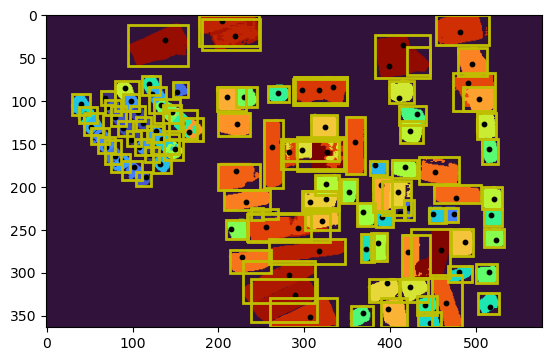

In [22]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
# Display background (e.g., zeros) 
ax.scatter(pixel_x, pixel_y, c='black', s=10) 
ax.imshow(mask_uint8[0,:,:], cmap='turbo')


# Iterate through boxes and add patches
for box in boxes_np:
    # box format is [xmin, ymin, xmax, ymax]
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), width, height, 
                            linewidth=2, edgecolor='y', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [23]:
import geopandas as gpd
from shapely.geometry import box

def convert_pixel_to_longlat(y, x):
    x_end, y_end = tif_data.xy(y, x)
    transformer = Transformer.from_crs(tif_data.crs, "EPSG:4326", always_xy=True)
    lon_end, lat_end = transformer.transform(x_end, y_end)
    return lon_end, lat_end 


boxes_np_list = list(boxes_np)

longlat_boxes = []

for x_min, y_min, x_max, y_max in boxes_np_list:
    lon_min, lat_min = convert_pixel_to_longlat(y_min, x_min)
    lon_max, lat_max = convert_pixel_to_longlat(y_max, x_max)

    longlat_boxes.append([lon_min, lat_min, lon_max, lat_max]) 

polygons = [box(minx, miny, maxx, maxy) for minx, miny, maxx, maxy in longlat_boxes]

# 3. Create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

# 4. Save to GeoJSON
gdf.to_file("bounding_boxes.geojson", driver='GeoJSON')


In [24]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image")
m.add_raster(clipped_image_file, layer_name="Theos")
m.add_circle_markers_from_xy(center_geojson, radius=3, color="red", fill_color="yellow", fill_opacity=0.8
)
m.add_raster(extracted_masks, cmap="jet", nodata=0, opacity=0.7, layer_name="Building masks")
m.add_vector("bounding_boxes.geojson", layer_name="Vector Data")
m

Map(center=[13.05335, 100.92455000000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

## E. Viewing and improving the mask 

In [25]:
extracted_masks = "clipped_satellite_mask2.tif" 

In [26]:
mask, tif_data, [lons, lats], [rows, cols] = get_raster_data(extracted_masks)
mask_uint8 = mask.astype(np.uint8) # mask max value = 105

Dataset name: clipped_satellite_mask2.tif
File mode: r
Number of bands: 1
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (1, 364, 578)
Data type: int32


In [27]:
mask.max()

105